In [1]:
# import csv

# # Paths to your CSV files
# source_csv_path = 'news_sentiment_analysis.csv'
# destination_csv_path = 'a1_IMDB_Dataset.csv'

# # Reading data from the first CSV file
# with open(source_csv_path, 'r', newline='', encoding='utf-8') as source_file:
#     reader = csv.DictReader(source_file)
    
#     # Prepare data to append to the second CSV file
#     data_to_append = []
#     for row in reader:
#         data_to_append.append({
#             "review": row["Description"],
#             "sentiment": row["Sentiment"]
#         })

# # Writing the data to the second CSV file
# with open(destination_csv_path, 'a', newline='', encoding='utf-8') as dest_file:
#     writer = csv.DictWriter(dest_file, fieldnames=["review", "sentiment"])
    
#     # Only write the header if the file is empty
#     if dest_file.tell() == 0:
#         writer.writeheader()

#     # Append the data
#     for entry in data_to_append:
#         writer.writerow(entry)


In [2]:
import pandas as pd
import numpy as np  
import re
from nltk.corpus import stopwords
from numpy import array 


from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Dense
from sklearn.model_selection import train_test_split

2024-09-08 18:33:40.520695: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-08 18:33:40.525643: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-08 18:33:40.541682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 18:33:40.568234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 18:33:40.576082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 18:33:40.595309: I tensorflow/core/platform/cpu_feature_gu

In [3]:
news = pd.read_csv("a1_IMDB_Dataset.csv")
news.shape

(53500, 2)

In [4]:
news.head(-5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
53490,Russell Investments Group Ltd. boosted its hol...,positive
53491,Samyang Corp Showcases Specialty Ingredients a...,neutral
53492,"WESTFORD, Mass., July 18, 2024 /PRNewswire/ --...",neutral
53493,QRG Capital Management Inc. trimmed its positi...,positive


<Axes: xlabel='sentiment', ylabel='count'>

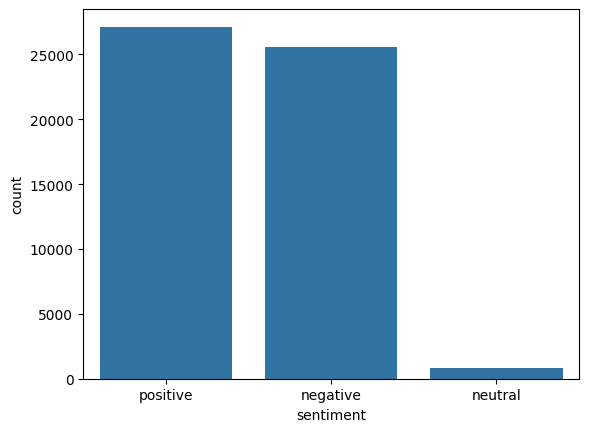

In [5]:
import seaborn as sns
sns.countplot(x='sentiment', data=news)

In [6]:
news["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/zaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [10]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(news["review"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [11]:
X[0]

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skill

In [12]:
# Converting sentiment labels to 0 to netutral, -1 negative, 1 positive

y = news['sentiment']

y = np.array(list(map(lambda x: 0 if x== "negative" else 1 if x == "positive" else 2, y)))

print(y[0], y[1], y[3])

1 1 0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [15]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

98917

In [16]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [18]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
embedding_matrix.shape

(98917, 100)

## CNN

In [20]:
from keras.layers import Conv1D

In [21]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

I0000 00:00:1725842075.517669   50522 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-08 18:34:35.518470: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,891,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,891,700 (37.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,891,700 (37.73 MB)

None


In [23]:
# Model training 
epochsnum = 6
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=epochsnum, verbose=1, validation_split=0.2)

Epoch 1/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - acc: 0.7034 - loss: 0.4992 - val_acc: 0.8103 - val_loss: 0.2749
Epoch 2/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - acc: 0.8285 - loss: 0.2272 - val_acc: 0.8169 - val_loss: 0.1699
Epoch 3/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - acc: 0.8518 - loss: 0.0981 - val_acc: 0.8207 - val_loss: 0.0565
Epoch 4/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - acc: 0.8642 - loss: -0.0765 - val_acc: 0.8146 - val_loss: -0.0576
Epoch 5/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - acc: 0.8773 - loss: -0.3144 - val_acc: 0.7972 - val_loss: -0.1776
Epoch 6/6
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - acc: 0.8902 - loss: -0.5331 - val_acc: 0.8055 - val_loss: -0.4029


In [24]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

335/335 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.7953 - loss: -0.2173


In [25]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: -0.2543851435184479
Test Accuracy: 0.8014018535614014


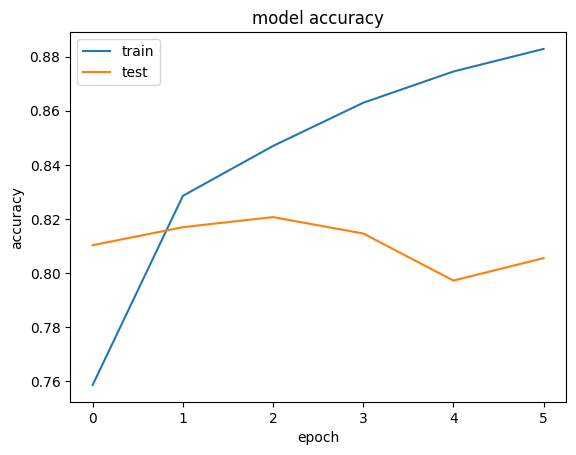

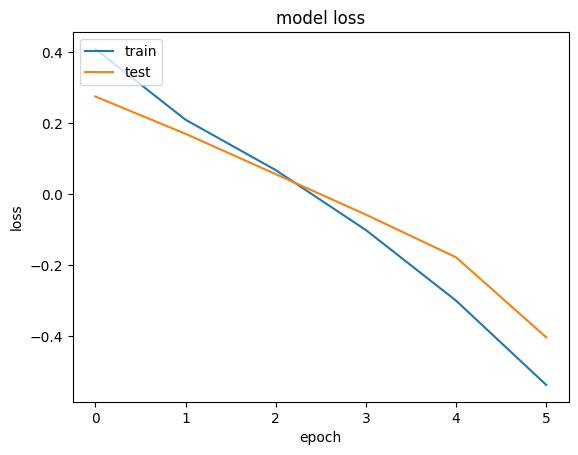

In [26]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [27]:
cnn_model.save(f"./nnconv_im_ds_epochs_{epochsnum}_acc_{round(score[1], 3)}.h5", save_format='h5')

In [28]:
from keras.models import load_model

model_path ='./nnconv_im_ds_epochs_6_acc_0.8.h5'
pretrained_cnn_model = load_model(model_path)

In [29]:
new = ["Israeli operation in occupied West Bank leaves at least 10 dead in largest raid in decades. Foreign Minister Israel Katz called the assault part of a full-fledged war.", 
       "Verdict expected in sedition trial of two Hong Kong journalists. Chung Pui-kuen and Patrick Lam, who led the defunct pro-democracy newspaper Stand News, pleaded not guilty in a trial seen as a test of press freedom in the Chinese territory.",
       "Hostage held by Hamas in Gaza rescued by Israeli forces, IDF says. Qaid Farhan Alkadi, 52, was rescued by troops with Shayetet 13, the 401st Brigade, in a “complex operation” in southern Gaza, the Israel Defense Forces and Shin Bet said.",
       "Video reveals devastation and grief after Gaza tent camp is shelled. NBC News' crew captures the moments when 8-year-old Abdullah Samour is rushed to the hospital as Palestinians race frantically to save victims of the bombing."
]

In [33]:
unseen_processed = []
for n in new:
  guess = preprocess_text(n)
  unseen_processed.append(guess)

unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
unseen_tokenized

[[5266,
  4140,
  7713,
  1024,
  1753,
  752,
  114,
  226,
  5715,
  8541,
  2498,
  1836,
  3762,
  5461,
  34759,
  312,
  4144,
  72,
  238,
  16561,
  184],
 [7005,
  717,
  79408,
  2814,
  29,
  2693,
  1999,
  12510,
  20268,
  2177,
  8608,
  1383,
  17382,
  2918,
  8698,
  3898,
  648,
  826,
  29288,
  2205,
  2814,
  32,
  2060,
  3082,
  1851,
  1565,
  3335],
 [5262,
  1259,
  19188,
  15714,
  5973,
  5266,
  1674,
  84482,
  400,
  70634,
  5973,
  4593,
  1000,
  9034,
  1121,
  4140,
  2562,
  15714,
  5461,
  3588,
  1674,
  8942,
  2058,
  175],
 [252,
  2687,
  12349,
  5228,
  15714,
  11226,
  1061,
  35706,
  4086,
  826,
  732,
  2228,
  266,
  161,
  59,
  36954,
  3359,
  1215,
  15713,
  1238,
  16003,
  466,
  1395,
  6891]]

In [34]:
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [35]:
# Passing tokenised instance to the cnn model for predictions
unseen_sentiments = pretrained_cnn_model.predict(unseen_padded)

unseen_sentiments

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([[0.78957146],
       [1.        ],
       [0.99631673],
       [0.8898202 ]], dtype=float32)